In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.4 MB/s 


In [3]:
# import necessary stuff

import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import *
from keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import h5py as h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications, optimizers
import kerastuner
from tensorflow.keras.regularizers import l2

import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [4]:
train_data_dir = "/content/drive/MyDrive/DGU_Ensemble model/dataset_penyu/train"
valid_data_dir = "/content/drive/MyDrive/DGU_Ensemble model/dataset_penyu/valid"
test_data_dir = "/content/drive/MyDrive/DGU_Ensemble model/dataset_penyu/test"

# ***EDA***

In [5]:
os.listdir(train_data_dir) # all folders (i.e. classes) in train returned as a 
# all classes match

['Lepidochelys olivacea',
 'Chelonia mydas',
 'Eretmochelys imbricata',
 'Caretta caretta']

In [6]:
os.listdir(valid_data_dir) # all folders (i.e. classes) in validation returned as a list
# all classes match

['Caretta caretta',
 'Chelonia mydas',
 'Lepidochelys olivacea',
 'Eretmochelys imbricata']

In [7]:
os.listdir(test_data_dir) # all folders (i.e. classes) in validation returned as a list
# all classes match

['Lepidochelys olivacea',
 'Caretta caretta',
 'Eretmochelys imbricata',
 'Chelonia mydas']

In [8]:
# check no of images in training and validation datasets

train = []
valid = []
test = []

for i in os.listdir(train_data_dir): # /validation as all have same folders (classes)
  #print(i)
  train.extend(os.listdir(os.path.join(train_data_dir, i))) # so 
  #the classes(which are all same in training/ validation/ evaluation) and their respective elements gets added to the train list class(i) wise
  valid.extend(os.listdir(os.path.join(valid_data_dir, i))) # so 
  #the classes(which are all same in training/ validation/ evaluation) and their respective elements gets added to the train list class(i) wise
  test.extend(os.listdir(os.path.join(test_data_dir, i))) # so 
  #the classes(which are all same in training/ validation/ evaluation) and their respective elements gets added to the valid list class(i) wise

print('No of training images: ', len(train)) # total no of images only for train 
print('No of training images: ', len(valid)) # total no of images only for train 
print('No of testing images: ', len(test)) # total no of images only for valid

No of training images:  2520
No of training images:  720
No of testing images:  360


# Model Parameter

In [9]:
batch_size = 16
EPOCHS = 300
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 10
DECAY_DROP = 0.5

# ***DATA PRE-PROCESSING (AUGMENTATION)***

In [10]:
  #np.random.seed(101)
  
  # create runtime Data Augmentation on train/valid set in batches
  train_datagen = ImageDataGenerator(
      rescale = 1./255, # normalize images /255 as 0-255 values would be too high for our models to process (given a typical learning rate)
      zoom_range = 0.1, # randomly zooming inside pictures
      horizontal_flip = True, # randomly flipping half of the images horizontally                                                 
  )
  # create runtime Data Augmentation on test set in batches
  test_datagen = ImageDataGenerator(
      rescale = 1./255 # normalize images only and nothing else since testing                                                                                                   
  )



  # create data generator for training dataset
  train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                      target_size = (224, 224),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical') # binary could have been used
  # train_generator performs normalization, zooming in, and horizontal flipping

    # create data generator for training dataset
  valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                      target_size = (224, 224),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical') # binary could have been used
  # valid_generator performs normalization, zooming in, and horizontal flipping

  # create data generator for validation dataset
  test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                      target_size = (224, 224),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical') # because we have 2 classes here
  # test_generator performs normalization only

Found 2520 images belonging to 4 classes.
Found 720 images belonging to 4 classes.
Found 360 images belonging to 4 classes.


# Define Model

In [11]:
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.InceptionV3(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.15)(x)
x =tf.keras.layers.Dense(256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.15)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)

87924736/87910968 [==============================] - 0s 0us/step


In [12]:
for layer in model.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 batch_normalization_15 (BatchN  (None, 25, 25, 64)  192         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 25, 25, 48)   12288       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_15[0][0]']          
                                                                                                  
 batch_nor

In [13]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/2
157/157 [==============================] - 867s 5s/step - loss: 1.1600 - accuracy: 0.5371 - val_loss: 0.9459 - val_accuracy: 0.6056
Epoch 2/2
157/157 [==============================] - 49s 310ms/step - loss: 0.8170 - accuracy: 0.6729 - val_loss: 0.8882 - val_accuracy: 0.6542
Waktu Training: 1013.5760672092438


In [14]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_7 (Activation)      (None, 25, 25, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 25, 25, 96)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 mixed0 (Concatenate)           (None, 25, 25, 256)  0           ['activation_5[0][0]',           
                                                                  'activation_7[0][0]',           
                                                                  'activation_10[0][0]',          
          

In [15]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/300
157/157 [==============================] - 65s 353ms/step - loss: 1.1022 - accuracy: 0.5379 - val_loss: 4.0277 - val_accuracy: 0.3931
Epoch 2/300
157/157 [==============================] - 51s 325ms/step - loss: 0.8812 - accuracy: 0.6530 - val_loss: 3.7782 - val_accuracy: 0.4153
Epoch 3/300
157/157 [==============================] - 52s 331ms/step - loss: 0.7275 - accuracy: 0.7308 - val_loss: 14.0228 - val_accuracy: 0.3986
Epoch 4/300
157/157 [==============================] - 51s 322ms/step - loss: 0.6696 - accuracy: 0.7572 - val_loss: 1.0866 - val_accuracy: 0.5208
Epoch 5/300
157/157 [==============================] - 52s 331ms/step - loss: 0.5898 - accuracy: 0.7887 - val_loss: 1.2924 - val_accuracy: 0.5806
Epoch 6/300
157/157 [==============================] - 51s 326ms/step - loss: 0.4974 - accuracy: 0.8267 - val_loss: 0.9419 - val_accuracy: 0.6417
Epoch 7/300
157/157 [==============================] - 52s 333ms/step - loss: 0.4889 - accuracy: 0.8335 - val_loss: 0.9653 

# Model Graph

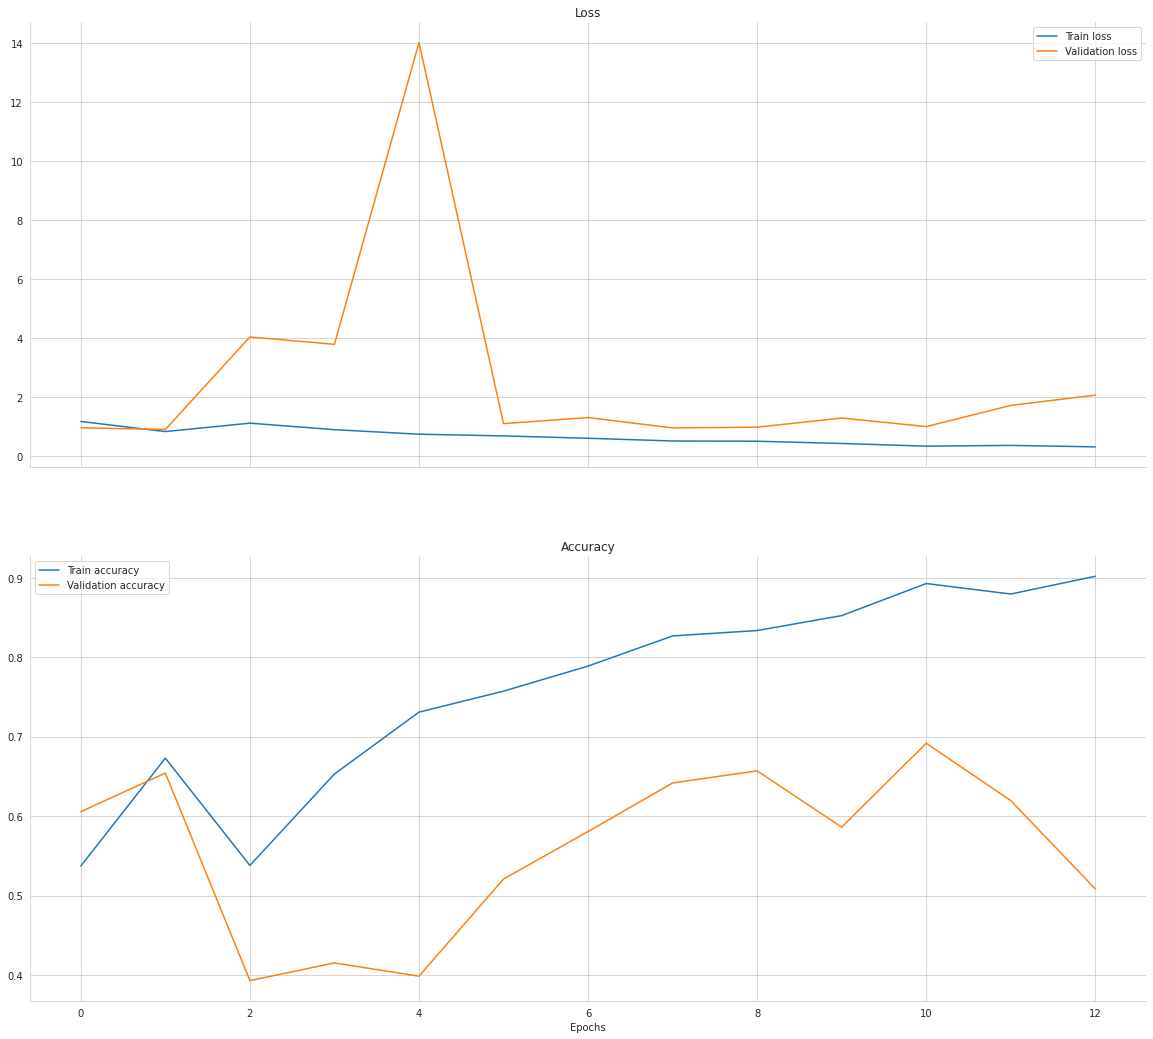

In [16]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# ***VISUALIZE THE RESULTS***

In [31]:
# assign labels to the corresponding indexes

labels = {
    0:'Lepidochelys olivacea', 
    1: 'Chelonia mydas',
    2: 'Eretmochelys imbricata',
    3: 'Caretta caretta'
          }

In [32]:
# loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []

count = 0

for i in os.listdir(test_data_dir):
  for item in os.listdir(os.path.join(test_data_dir, i)):
    # code to open the image
    img= PIL.Image.open(os.path.join(test_data_dir, i, item))
    # resizing the image to (256,256) because model was previously trained on such a dimension
    img = img.resize((224,224))
    # appending image to the image list
    #type(img)
    image.append(img)
    # converting image to array
    img = np.asarray(img, dtype= np.float32)
    # normalizing the image
    img = img / 255
    # reshaping the image in to a 4D array
    img = img.reshape(-1,224,224,3) #                                                                                                   ???????????????
    # making prediction of the model
    predict = model.predict(img)
    # getting the index corresponding to the highest value in the prediction (the most probable class the model is predicting)
    predict = np.argmax(predict)
    # appending the predicted class to the list
    prediction.append(labels[predict])
    # appending original class to the list
    original.append(i)

In [33]:
img.shape

(1, 224, 224, 3)

In [34]:
# get testing accuracy 

score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.37777777777777777


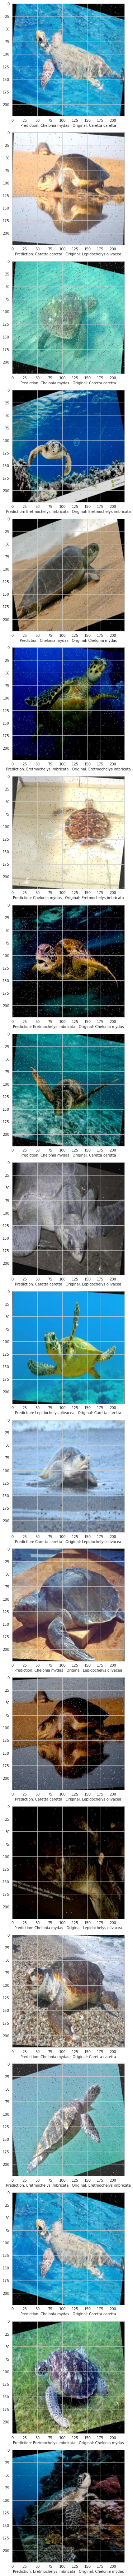

In [35]:
# visualizing the results

import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction: " + prediction[j] + "   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [36]:
# classification report

print(classification_report(np.asarray(original), np.array(prediction)))

                        precision    recall  f1-score   support

       Caretta caretta       0.16      0.20      0.18        90
        Chelonia mydas       0.44      0.56      0.49        90
Eretmochelys imbricata       0.64      0.76      0.69        90
 Lepidochelys olivacea       0.00      0.00      0.00        90

              accuracy                           0.38       360
             macro avg       0.31      0.38      0.34       360
          weighted avg       0.31      0.38      0.34       360



Text(0.5, 1.0, 'Confusion_matrix')

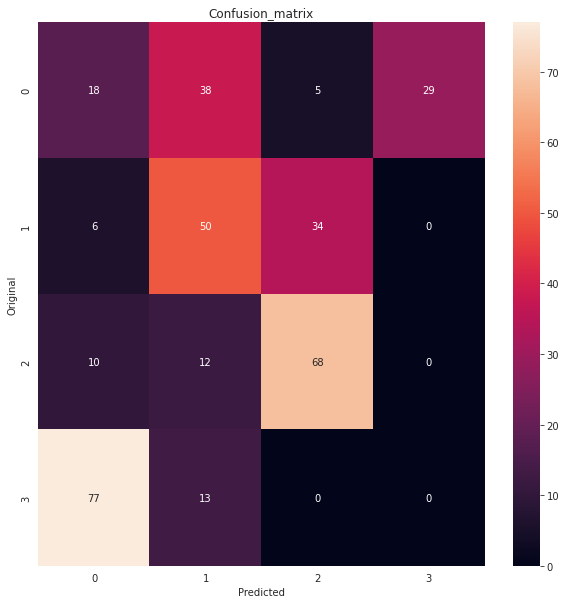

In [37]:
# plot confusion matrix

plt.figure(figsize=(10,10))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [38]:
model.save('/content/drive/MyDrive/DGU_Ensemble model/hasil_Inception.h5')